In [13]:
import sys
sys.path.append('../')
from data_loader import DataLoader
import random
from feature_selector import BaselineSelector
from feature_selector import AnalysisSelector
from feature_selector import FeatureExtractor
import numpy as np

In [2]:
loader = DataLoader('../data/dataset', participants_ids=list(range(88)))
selectors = [None] * 19
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:

mean_cum_sum = np.zeros((19, ))
mean_pca_var = np.zeros((19, ))

for i in range(len(loader)):
    data = loader[i]['data']
    pca = PCA()
    pca.fit(data)
    exp_var_pca = pca.explained_variance_ratio_
    mean_pca_var += exp_var_pca

    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    mean_cum_sum += cum_sum_eigenvalues

mean_cum_sum /= len(loader)
mean_pca_var /= len(loader)


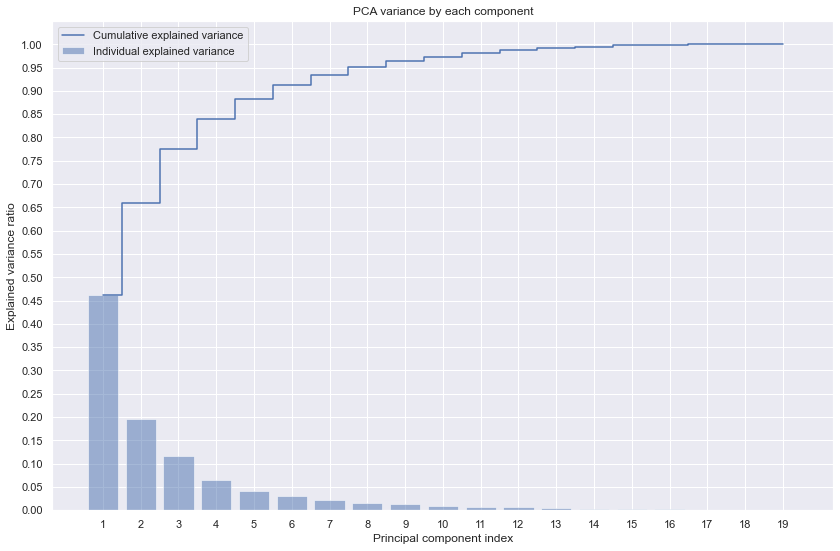

In [44]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(14, 9))
plt.grid()
sns.set(style='darkgrid')
plt.grid()
plt.bar(range(1,len(mean_pca_var)+1), mean_pca_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(mean_cum_sum)+1), mean_cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xticks(list(range(1, 20)))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.title('PCA variance by each component')
plt.savefig('../data/plots/pca/pca.png', dpi = 300)
plt.show()

### Sa ovog grafika mozemo videti da ako uzmemo 8 komponenti, hvatamo preko 95% varijance u podacima. Tako da cemo koristiti 8 komponenti PCA za dalju analizu.

In [25]:
selector = BaselineSelector()
selector.selectFeatures(['mean', 'std', 'kurtosis', 'band_power'], pca_components=8, bands = ['alpha', 'beta', 'gamma', 'theta'])

In [29]:
tmp = selector.transform(loader[0]['data'])

In [32]:
features = None

for i, sample in enumerate(loader):
    data = sample['data']
    f = selector.transform(data)
    if features is None:
        features = np.expand_dims(f, axis=0)
    else:
        features = np.concatenate((features, np.expand_dims(f, axis=0)), axis=0)
        if i % 1000 == 0:
            print(f'{i} samples processed')
            
        

1000 samples processed
2000 samples processed
3000 samples processed
4000 samples processed
5000 samples processed
6000 samples processed
7000 samples processed
8000 samples processed
9000 samples processed
10000 samples processed
11000 samples processed
12000 samples processed


<AxesSubplot:>

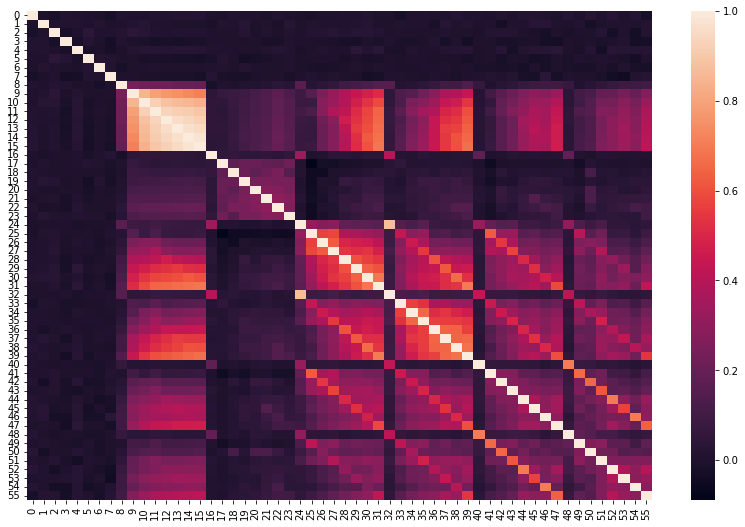

In [34]:
# plot pearson correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

corr = np.corrcoef(features, rowvar=False)
corr = pd.DataFrame(corr)

fig, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)



In [20]:
for i in range(len(loader)):
    arr = loader[i]['data']
    selector2 = AnalysisSelector() 
    selector2.selectFeatures(['hjorth_params', 'mean', 'band_power', 'kurtosis'], pca_components = 8, params=['complexity', 'mobility'], bands=['alpha', 'beta', 'gamma', 'theta'])
    out2 = selector2.transform(arr)
    out2 = [list(i) for i in list(out2.values())]
    print(out2)
    break

[[6.1450067, 1.5787047, 1.4434657, 1.689889, 1.5135084, 1.4501851, 1.3385202, 1.5652765], [0.0596839, 0.2742894, 0.30647957, 0.25578764, 0.28736454, 0.29997048, 0.32428998, 0.26863214], [-1.5200806e-05, -4.459381e-06, 3.521347e-06, 1.304245e-06, -2.3631096e-06, -7.0380243e-06, 1.1730433e-06, -2.550602e-07], [137.65284261534717, 27.470478436966975, 8.439891474360426, 8.066243230251171, 1.8482110924597028, 1.9097703964168025, 0.8958385939839154, 0.94012322196688], [2.4298160631227805, 0.10798283187155402, 0.03203465602089907, 0.08904221965798598, 0.023000712807701957, 0.017066029898931478, 0.009230418542809172, 0.007850202148519994], [1.6814321585452453e-05, 1.374556875386425e-06, 4.5356107579213026e-07, 1.1784056234313083e-06, 6.26349494733829e-08, 6.475930179313542e-08, 1.0873282553525904e-07, 5.34651080386224e-08], [8.49303051837659e-08, 1.4975030807487887e-08, 3.4972218425214396e-09, 1.10731322387622e-09, 1.2526369056778064e-10, 1.2392813674263142e-09, 1.0619715084352726e-09, 2.57696